# TRF encoding results: 4 models

In [1]:
# This cell returns figures in svg format
%config InlineBackend.figure_formats = ['png']

import h5py
import numpy as np
import pandas as pd
from itertools import product, combinations
from os.path import join as pjoin

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

ispeech


---
---
**TRF Models** correspond to:
1. Envelope & low (i.e. 1-9Hz)
1. Envelope & HFa (i.e. 80-120Hz)
1. PeakRate & low (i.e. 1-9Hz)
1. PeakRate & HFa (i.e. 80-120Hz)

In [2]:
# some helper functions

from matplotlib import colors


def jn(mlist, char=None):
    if not char:
        char = '_'
    string = char.join(mlist)
    return string


def flatten(nested):
    flatl = [item for sublist in nested for item in sublist]
    empty_l = [np.asarray(flatl).shape[i]
               for i in range(np.asarray(flatl).ndim)]
    tup = tuple(empty_l)
    flat_list = np.array(flatl).reshape(tup)
    return flat_list


def split_hemis(chlist):
    left_names, right_names = [], []
    left_index, right_index = [], []
    for i, ch in enumerate(chlist):
        if "'" in ch:
            left_names.append(ch)
            left_index.append(i)
        else:
            right_names.append(ch)
            right_index.append(i)
    return (left_names, right_names, left_index, right_index)


def blended_cmap(rgb_color_list):
    if not isinstance(rgb_color_list, list):
        raise ValueError('Colors must be passed as a list.')
    elif len(rgb_color_list) < 2:
        raise ValueError('Must specify at least 2 colors.')
    elif (
        not isinstance(rgb_color_list[0], list)
        or not isinstance(rgb_color_list[1], list)
    ) or (
        len(rgb_color_list[0]) != 3 or len(rgb_color_list[1]) != 3
    ):
        raise ValueError(
            'Each color should be represented as a list of size 3.'
        )
    N, entries = 256, 4  # red, green, blue, alpha
    rgbas = np.ones((N, entries))
    segment_count = len(rgb_color_list) - 1
    segment_size = N // segment_count
    remainder = N % segment_count  # need to add this back later
    for i in range(entries - 1):  # we don't alter alphas
        updates = []
        for seg in range(1, segment_count + 1):
            # determine how much needs to be added back to account for remainders
            offset = 0 if not remainder or seg > 1 else remainder
            updates.append(np.linspace(
                start=rgb_color_list[seg - 1][i],
                stop=rgb_color_list[seg][i],
                num=segment_size + offset
            ))
        rgbas[:, i] = np.concatenate(updates)

    return colors.ListedColormap(rgbas)


def cmap_custom(gradient, bottom_color=None, top_color=None, middle_color=None):
    if gradient == 'diverging':
        if bottom_color is None:
            bottom_color = color['music'][2]
        rgbs = [bottom_color / 255,
                np.array((255, 255, 255)).reshape(1, -1) / 255, top_color / 255]
    else:
        if bottom_color is None:
            # set bottom to white
            bottom_color = np.array((255, 255, 255)).reshape(1, -1)
        rgbs = [bottom_color / 255, top_color / 255]

    rgbs = [list(x[0]) for x in rgbs]
    cmap = blended_cmap(rgbs)
    return cmap


def set_cmapnorm(effect, bottom, top, sound=None, center=0., alpha=False):
    if effect[0] == 'main':
        norm = colors.Normalize(vmin=bottom, vmax=top)
        o_cmap = cmap = cmap_custom(
            gradient='gradient', top_color=color[sound][1])
        if alpha:
            cmap = o_cmap(range(o_cmap.N))
            cmap[:, -1] = np.linspace(0.15, 1, o_cmap.N)
            cmap = colors.ListedColormap(cmap)
    return (cmap, norm)

**Fixed variables** 

In [3]:
analysis = 'TRF'
alpha = .01
d = {}

*Lists*

In [4]:
envtypes = ('env', 'abs_peakrate', )
bands = ('high', 'low', )
infos = ('wave', 'power', )

models = [jn([envtype, band, info])
          for envtype, band, info in product(envtypes, bands, infos)]
models = [x for x in models if 'low_power' not in x and 'high_wave' not in x]

sounds = ['speech', 'music']
hemis = ['left', 'right']

*Plotting colors and cmaps*

In [5]:
color = {
    'speech': [  # red
        np.array((242, 152, 154)).reshape(1, -1),
        np.array((254, 75, 73)).reshape(1, -1),
    ],
    'music': [  # blue
        np.array((148, 210, 221)).reshape(1, -1),
        np.array((43, 183, 200)).reshape(1, -1),
    ],
    'shared': [  # yellow tones
        np.array((255, 255, 255)).reshape(1, -1),
        np.array((255, 255, 255)).reshape(1, -1),
    ]}

## Prepare DataFrame

### **Collect base data** from presaved DF

In [6]:
with pd.HDFStore(pjoin('data', 'ispeech_trf.h5'), mode='r') as store:
    df = store.select('df')
sujs = np.unique(df.subject)
sujs

array(['sub-14c725b6b803', 'sub-26176ef8a8d0', 'sub-28e70e7c7fbb',
       'sub-3ef8645f99c5', 'sub-4247d6d6cdbf', 'sub-44375d501493',
       'sub-45a6830d263e', 'sub-82e330f8aadd', 'sub-83ebd5328120',
       'sub-95a634be7e05', 'sub-9d783b836f5e', 'sub-a4e7fc9daa96',
       'sub-c1b7ce54ce05', 'sub-c2a96116ddc4', 'sub-cacae171ee15',
       'sub-e0bb6ccef2a5', 'sub-ebf231d97f73', 'sub-fccb4adbfadc'],
      dtype=object)

## Find shared versus selective indices

### Shared and unique significant electrodes between sounds for each models contrast

In [7]:
trf = {}
for model in models:
    trf[model + '_shared_i'] = df.loc[(df['trf_main_%s_speech_new_sign' % model] > 0) & (
        df['trf_main_%s_music_new_sign' % model] > 0)]
    trf[model + '_speech_i'] = df.loc[(df['trf_main_%s_speech_new_sign' %
                                       model] > 0) & ~(df['trf_main_%s_music_new_sign' % model] > 0)]
    trf[model + '_music_i'] = df.loc[~(df['trf_main_%s_speech_new_sign' % model] > 0) & (
        df['trf_main_%s_music_new_sign' % model] > 0)]
    print(model, 'shared', len(trf[model + '_shared_i']), 'speech', len(
        trf[model + '_speech_i']), 'music', len(trf[model + '_music_i']))

env_high_power shared 146 speech 269 music 121
env_low_wave shared 310 speech 526 music 209
abs_peakrate_high_power shared 115 speech 157 music 97
abs_peakrate_low_wave shared 345 speech 545 music 215


## TRF **model comparison**

Comparing model 1 directly to the other models:
1. **Shared:** How many electrodes are significant between both models (i.e. model 1 and the model it is compared to) 
1. **Model 1:** How many electrodes are significant in model 1 and not represented in the other model
1. **Other model:** How many electrodes are significant in the other model and not represented in model 1

In [8]:
models

['env_high_power',
 'env_low_wave',
 'abs_peakrate_high_power',
 'abs_peakrate_low_wave']

### New Venn grouping sounds

In [9]:
# for i, main_model in enumerate(('env_low_power', 'abs_peakrate_low_power', )):
for i, main_model in enumerate(models):
    other_models = [x for x in models if x != main_model]
    mdf = df.loc[(df['trf_main_%s_%s_new_sign' % (main_model, 'speech')] > 0) | (
        df['trf_main_%s_%s_new_sign' % (main_model, 'music')] > 0)]

    for model in other_models:
        odf = df.loc[(df['trf_main_%s_%s_new_sign' % (model, 'speech')] > 0) | (
            df['trf_main_%s_%s_new_sign' % (model, 'music')] > 0)]

        trf[jn([main_model, model, 'combined_i'])] = set(
            list(mdf['chnames'].values) + list(odf['chnames'].values))

        trf[jn([main_model, model, 'shared_i'])
            ] = pd.merge(mdf, odf, how='inner')
        trf[jn([main_model, model, 'main_i'])] = [
            x for x in mdf['chnames'].values if x not in odf['chnames'].values]
        trf[jn([main_model, model, 'other_i'])] = [
            x for x in odf['chnames'].values if x not in mdf['chnames'].values]

        # print(sound, 'shared', len(trf[jn([sound, model, 'shared_i'])]), main_model, len(trf[jn(
        #     [sound, model, main_model, 'i'])]), model, len(trf[jn([sound, model, 'other_model_i'])]))

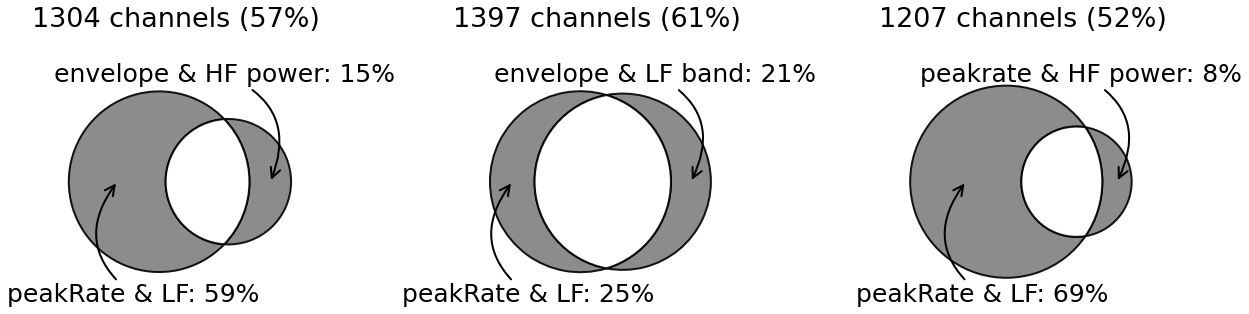

In [10]:
plt.figure(figsize=([57, 27]))
n0 = 0
for i, main_model in enumerate(('env_low_wave', 'abs_peakrate_low_wave', )[1:]):
    other_models = [x for x in models if x != main_model]
    new_list = ['main', 'other', 'shared']
    circles = ('10', '01', '11')
    for j, model in enumerate(other_models):
        # if n0 == 4: continue
        tmp = [len(trf[jn([main_model, model, x, 'i'])]) for x in new_list]
        name = '%s & %sF %s' % ('envelope' if model.startswith('env') else 'peakrate',
                                'L' if 'low' in model else 'H',
                                'band' if 'power' not in model else 'power')

        n0 += 1
        plt.subplot(1, 10, n0)
        # print('for %s the total number of sign channels is %s which comes down to %s%% of the data' % (jn([sound, model]), sum(np.array(tmp)), round(sum(np.array(tmp)) / len(df) * 100)))

        tmp = np.round(tmp / np.sum(tmp) * 100, 0).astype(int)
        c = venn2(tmp, set_labels=None, alpha=.9)
        c.get_patch_by_id('10').set_color('grey')
        c.get_patch_by_id('11').set_color('white')
        c.get_patch_by_id('01').set_color('grey')
        c.get_patch_by_id('11').set_edgecolor('black')
        c.get_patch_by_id('10').set_edgecolor('black')
        c.get_patch_by_id('01').set_edgecolor('black')

        # Total channel count
        ch_nr = len(trf[jn([main_model, model, 'combined_i'])])
        plt.annotate('%s channels (%s%%)' % (ch_nr, round(ch_nr / len(df) * 100)),
                     # - np.array([0, 0.005]),
                     xy=c.get_label_by_id('01').get_position(),
                     xytext=(50, 155),
                     ha='right',
                     fontsize=27,  # + 3,
                     textcoords='offset points')

        for circle in circles:
            c.get_label_by_id(circle).set_text('')
        plt.annotate('%s: %s%%' % ('peakRate & LF' if main_model.startswith('abs') else 'envelope & LF', tmp[0]),
                     xy=c.get_label_by_id('10').get_position() -
                     np.array([0, 0.0005]),
                     xytext=(-110, -120),
                     ha='left',
                     fontsize=25,
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle='->',
                                     connectionstyle='arc3, rad=-0.5',
                                     color='black'))
        plt.annotate('%s: %s%%' % (name, tmp[1]),
                     xy=c.get_label_by_id('01').get_position() -
                     np.array([0, 0.0005]),
                     xytext=(125, 100),
                     ha='right',
                     fontsize=25,
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle='->',
                                     connectionstyle='arc3, rad=-0.5',
                                     color='black'))
    plt.tight_layout()

## Compare distributions

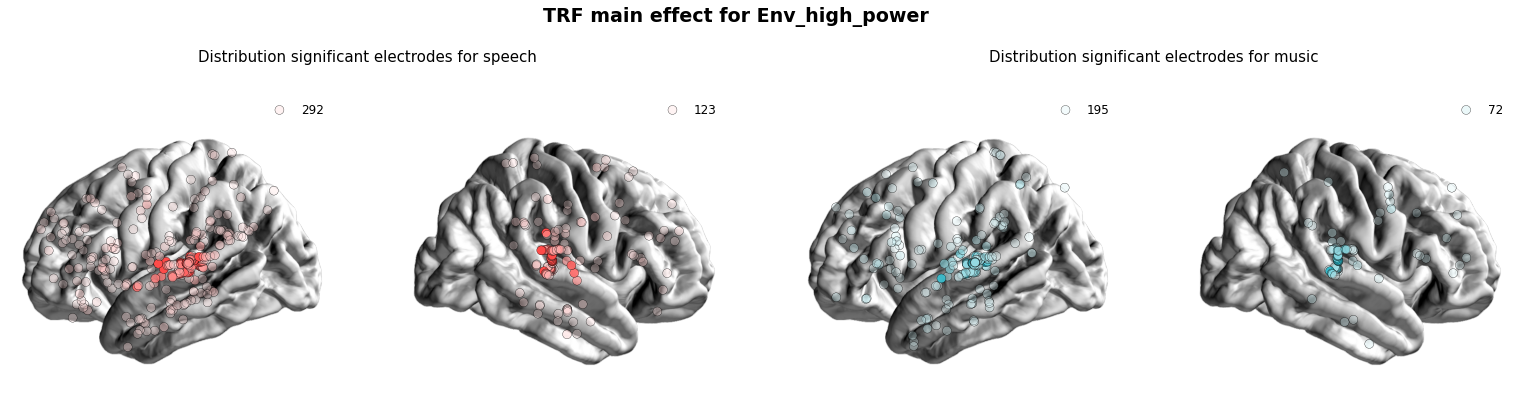

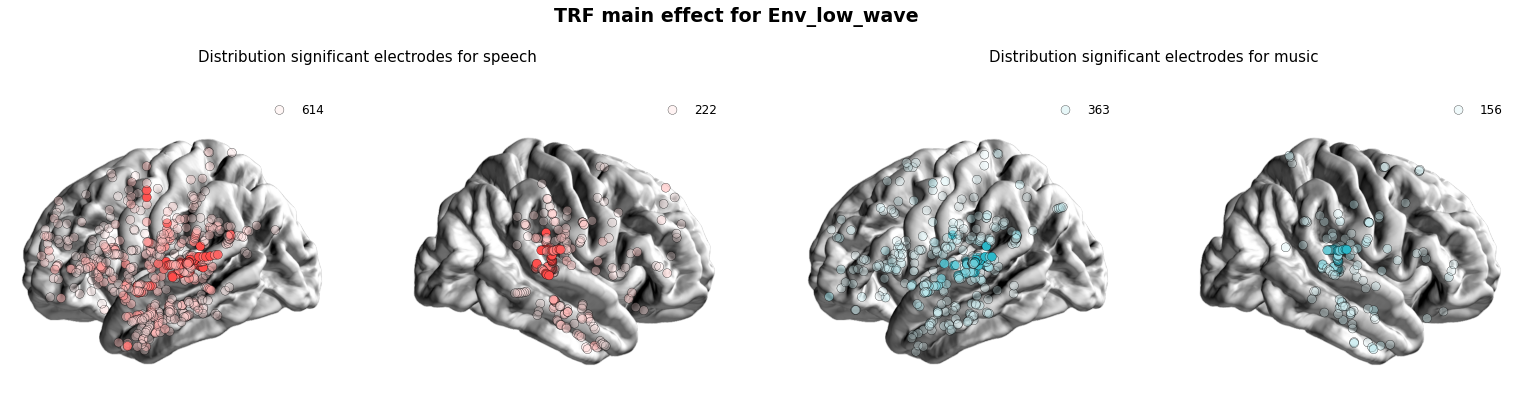

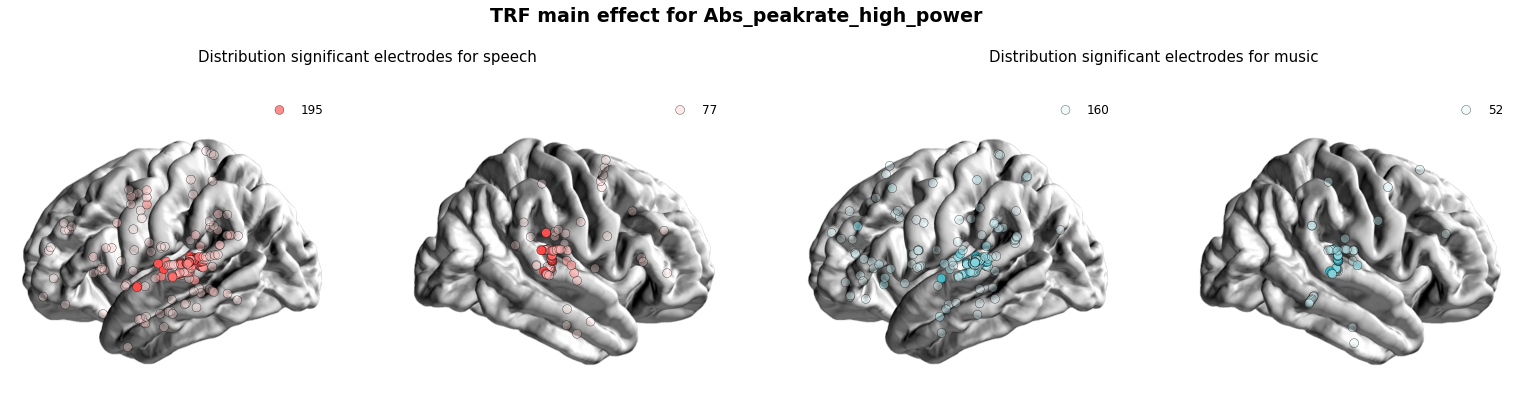

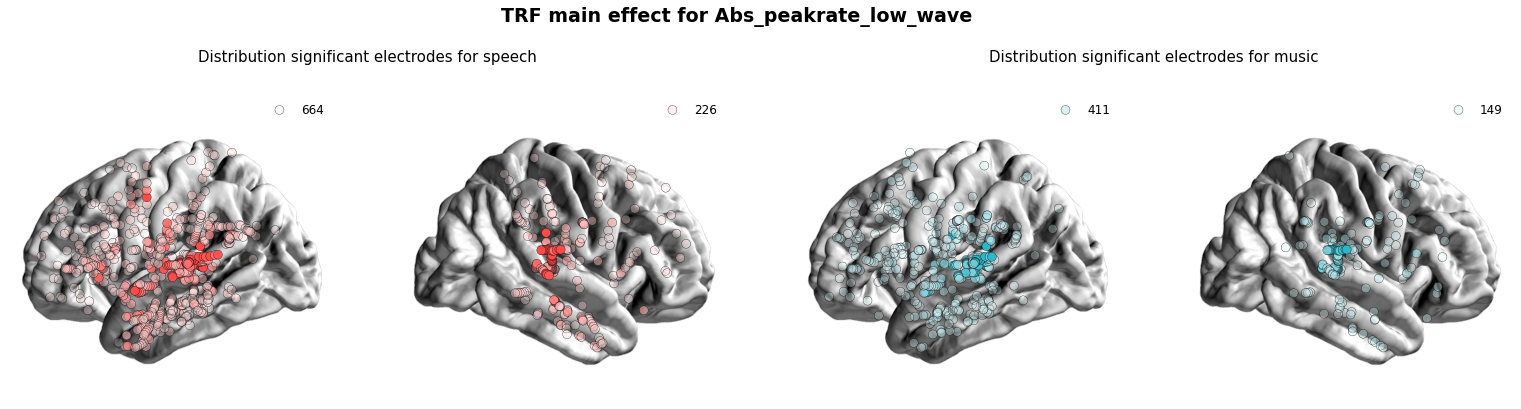

In [11]:
model = main_model  # 'model3'
for model in models:

    # prepare fig
    fig, ax = plt.subplots(1, len(hemis) * 2, figsize=(27, 7))
    fig.suptitle('%s main effect for %s' %
                 (analysis.upper(), model.capitalize()), weight='bold', fontsize=19)

    c = -1
    ext = []
    edge = .1
    for i, sound in enumerate(sounds):
        cmap, norm = set_cmapnorm(['main'], 0, .2, sound, alpha=True)
        for o, orientation in enumerate(hemis):
            c += 1
            axes = ax[c]
            with h5py.File(pjoin('data', 'bg_img.hdf5'), 'r') as hf:
                im = hf[orientation][...]

            temp_df = df.loc[(df['trf_main_%s_%s_new_sign' %
                              (model, sound)] > 0)]
            values = temp_df['trf_main_%s_%s_new_sign' % (model, sound)].values
            df_x = temp_df[jn([orientation, 'x'])].values
            df_y = temp_df[jn([orientation, 'y'])].values
            _, _, left_i, right_i = split_hemis(
                chlist=temp_df['chnames'].values)
            if orientation in ['left', 'right']:
                x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
                y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
                values_h = values[left_i] if orientation == 'left' else values[right_i]
            else:
                x_h = df_x
                y_h = df_y
                values_h = values

            if len(df_x) == 0:
                continue

            axes.imshow(im)
            axes.scatter(x_h,
                         y_h,
                         c=values_h,
                         cmap=cmap,
                         norm=norm,
                         label='%s' % (len(x_h)),
                         s=80 * np.ones(len(x_h)),
                         linewidth=0.3,
                         edgecolors='k')

            axes.set_axis_off()
            axes.legend(fancybox=True)

            # save the axes bounding boxes for later use
            ext.append([axes.get_window_extent().x0,
                       axes.get_window_extent().width])

    # from the axes bounding boxes calculate the optimal position of the column spanning title
    inv = fig.transFigure.inverted()
    width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2.
    left_center = inv.transform((width_left, 1))
    width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2.
    right_center = inv.transform((width_right, 1))

    # set column spanning title
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], 0.88, 'Distribution significant electrodes for speech',
                va="center", ha="center", size=15)
    plt.figtext(right_center[0], 0.88, 'Distribution significant electrodes for music',
                va="center", ha="center", size=15);